# LightFM Model for EBNeRD Dataset

Source: https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/lightfm_deep_dive.ipynb

## Shell

In [1]:
!pip install lightfm
!pip install git+https://github.com/microsoft/recommenders.git
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808330 sha256=78cc0fb062fe878fd9c94a325b0d9ab36dacf2535299e5f253180ec8e9de7933
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm
  Cloning https://github.com/microsoft/recommenders.git to /tmp/pip-req-build-0e8zgt8v
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/recommenders.git /tmp/pip-req-build-0e8zgt8v
  Resolved https://github.com/microsoft/recommenders.git to commit c2ea583d27bb1a4d58a09a1621d5ce95672ef1dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Importing libraries

In [2]:
import os
import sys
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics,
    prepare_test_df,
    prepare_all_predictions,
    compare_metric,
    similar_users,
    similar_items,
)
from recommenders.utils.notebook_utils import store_metadata
from torch.utils.tensorboard import SummaryWriter

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
LightFM version: 1.17


## Defining variables

In [3]:
# Adjusted hyperparameters
NO_COMPONENTS = 30  # Increase the number of latent factors
NO_EPOCHS = 60      # Increase the number of epochs
LEARNING_RATE = 0.1 # Adjust the learning rate
ITEM_ALPHA = 1e-7   # Adjust regularization for item features
USER_ALPHA = 1e-7   # Adjust regularization for user features

# default number of recommendations
K = 10
# no of threads to fit model
NO_THREADS = 32
# seed for pseudonumber generations
SEED = 42

## Retrieving data

The data is pre-prepared to fit with the basic LightFM model. During data preparation, duplicate data, and common items between training and validation datasets are removed.

#### Retrieve training and test data - EBNeRD

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_data = pd.read_csv("/content/drive/MyDrive/train_data_alt.csv")
train_data.sample(5, random_state=SEED)

,userID,itemID,rating,genre
3604570,543192,9773248,0,Kriminalitet
829952,1436006,9773018,0,Kendt
2295263,318801,9763668,1,Begivenhed
2939146,1162980,9769341,0,Kendt
105927,87106,9764008,1,Katastrofe


In [6]:
test_data = pd.read_csv("/content/drive/MyDrive/valid_data_alt.csv")
test_data.sample(5, random_state=SEED)

,userID,itemID,rating,genre
2917710,1192315,9779066,0,Kendt
2560797,308851,9756047,1,Katastrofe
3009893,1078040,9788692,0,Erhverv
1655188,2006987,9782319,0,Erhverv
1108331,1270856,9768469,1,Begivenhed


### Prepare data

LightFM requires internal mapping of userID and itemID. The mapping is shares accross training and validation to ensure consistency.

In [7]:
# Create a single Dataset instance to handle mappings for both datasets
dataset = Dataset()
dataset.fit(users=pd.concat([train_data['userID'], test_data['userID']]),
            items=pd.concat([train_data['itemID'], test_data['itemID']]))

### Sanity check

In [8]:
(train_interactions, train_weights) = dataset.build_interactions(train_data.iloc[:, 0:3].values)
(test_interactions, test_weights) = dataset.build_interactions(test_data.iloc[:, 0:3].values)

print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of validation interactions: {test_interactions.shape}")

Shape of train interactions: (18827, 13018)
Shape of validation interactions: (18827, 13018)


## Fit the LightFM model

In [9]:
model = LightFM(loss='warp', no_components=NO_COMPONENTS,
                learning_rate=LEARNING_RATE,
                random_state=np.random.RandomState(SEED))

In [10]:
model.fit(interactions=train_interactions, epochs=NO_EPOCHS);

## Get validation AUC score

In [11]:
from lightfm.evaluation import auc_score

# Exclude interactions in the training set from the test set
test_interactions_excl_train = test_interactions - train_interactions.multiply(test_interactions)

# Calculate AUC score
with Timer() as auc_time:
    auc_scores = auc_score(model, test_interactions=test_interactions_excl_train,
                           num_threads=NO_THREADS)

print(f"Took {auc_time.interval:.1f} seconds to calculate AUC scores.")

# Get the number of AUC scores and calculate the average AUC score
num_auc_scores = len(auc_scores)
average_auc_score = np.mean(auc_scores)

# Print the number of AUC scores and average AUC score
print("Number of AUC scores calculated:", num_auc_scores)
print("Average AUC score:", average_auc_score)

Took 64.9 seconds to calculate AUC scores.
Number of AUC scores calculated: 15342
Average AUC score: 0.4887601


## Track training and validation AUC score for each epoch to see convergence

Beware: Takes 40-50 minutes with 20 epochs.

In [ ]:
import matplotlib.pyplot as plt

# Initialize a SummaryWriter object
writer = SummaryWriter()

# Store AUC scores for each epoch
train_auc_scores_per_epoch = []
test_auc_scores_per_epoch = []

for epoch in range(NO_EPOCHS):
    # Fit model for current epoch
    model.fit_partial(interactions=train_interactions, epochs=1)

    # Calculate AUC score for current epoch
    train_auc_score_epoch = auc_score(model, train_interactions,
                                num_threads=NO_THREADS)

    test_auc_score_epoch = auc_score(model, test_interactions=test_interactions_excl_train,
                                num_threads=NO_THREADS)

    # Write AUC scores to TensorBoard
    writer.add_scalar('AUC/train', np.mean(train_auc_score_epoch), epoch)
    writer.add_scalar('AUC/test', np.mean(test_auc_score_epoch), epoch)

    # Append AUC score to list
    train_auc_scores_per_epoch.append(np.mean(train_auc_score_epoch))
    test_auc_scores_per_epoch.append(np.mean(test_auc_score_epoch))

    # Close the SummaryWriter object at the end
    writer.close()

### Plot

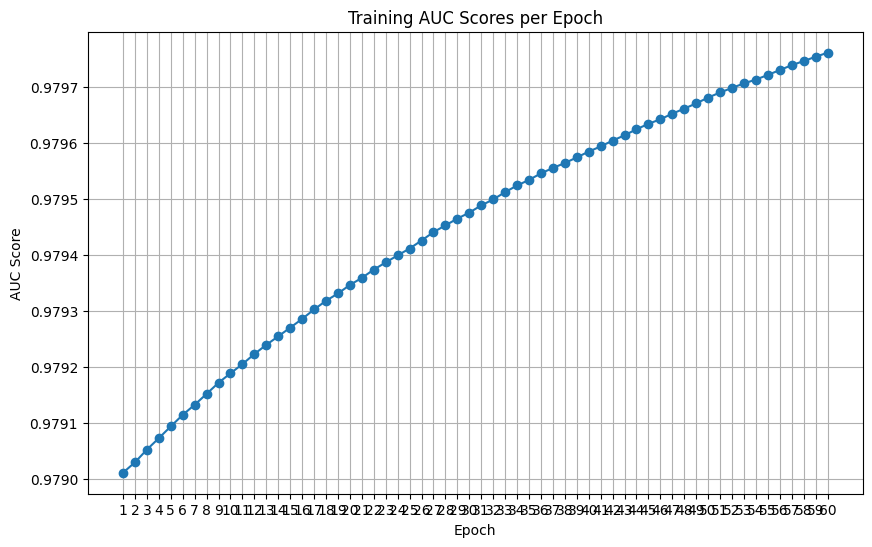

In [ ]:
# Plot AUC scores per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, NO_EPOCHS + 1), train_auc_scores_per_epoch, marker='o', linestyle='-')
plt.title('Training AUC Scores per Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(range(1, NO_EPOCHS + 1))
plt.show()

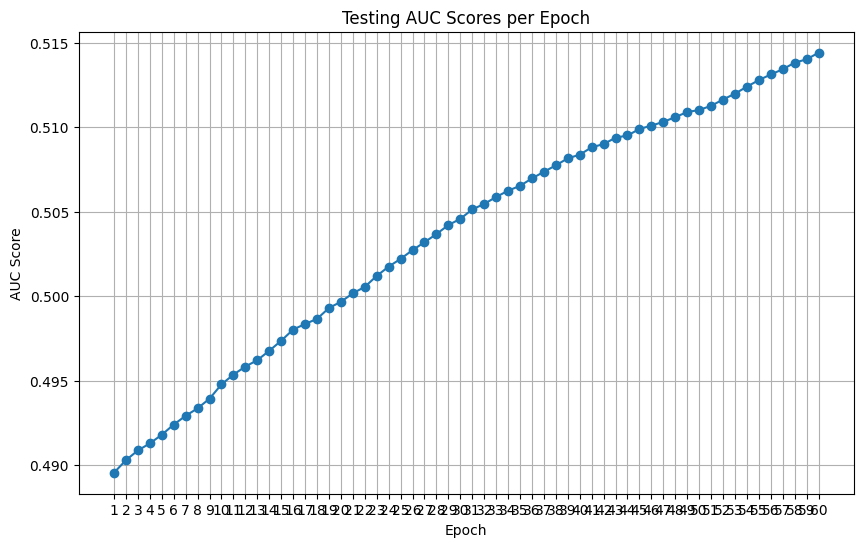

In [ ]:
# Plot AUC scores per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, NO_EPOCHS + 1), test_auc_scores_per_epoch, marker='o', linestyle='-')
plt.title('Testing AUC Scores per Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(range(1, NO_EPOCHS + 1))
plt.show()

## Make single prediction with single user id input and all articles

In [ ]:
def make_predictions_for_user(user_id):
    # Get the internal user ID for the given user ID
    internal_user_id = dataset.mapping()[0][user_id]

    # Get all item IDs from the dataset
    all_item_ids = np.array(list(dataset.mapping()[2].values()))

    # Make predictions
    predictions = model.predict(internal_user_id, all_item_ids)

    # Retrieve actual article IDs corresponding to internal item IDs
    actual_item_ids = np.array(list(dataset.mapping()[2].keys()))

    # Sort predictions and actual_item_ids based on predictions
    sorted_indices = np.argsort(predictions)[::-1]  # Sort indices in descending order
    sorted_predictions = predictions[sorted_indices]
    sorted_item_ids = actual_item_ids[sorted_indices]

    # Create a DataFrame with sorted item IDs and corresponding predictions
    df = pd.DataFrame({'Article ID': sorted_item_ids, 'Prediction': sorted_predictions})

    return df

# Example usage:
user_id = 1078040  # Specify the user ID for whom you want to make predictions
predictions_df = make_predictions_for_user(user_id)
print(predictions_df)

       Article ID  Prediction
0         8560195  -13.473782
1         9776099  -13.771854
2         9776238  -13.863147
3         9776259  -13.965599
4         9776190  -13.974963
...           ...         ...
13013     8433025  -27.030882
13014     9731041  -27.142254
13015     9535015  -27.159096
13016     4401001  -27.183147
13017     9730105  -28.135338

[13018 rows x 2 columns]


You can stop reading here, the rest of the notebook is not currently used.

## Export the model

In [ ]:
import joblib
joblib.dump(model, 'lightfm_model_joblib.joblib') # Use this one
#joblib.dump(model, 'lightfm_model.pkl')

['lightfm_model_joblib.joblib']

Tensorbor

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

<IPython.core.display.Javascript object>